# Problem 1

1. What is the market pricing to occur to the Federal Funds rate by end of next year?

The current Dec 2026 Fed Funds futures contract is trading at 96.74 which implies a fed funds rate of 3.26% (100 - 96.74) by the end of next year. This means that the market is pricing in ~ 4.3 cuts.

Calculation: 
- EFFR usually trades ≈ 5 bp below the mid‑point
- current Fed Funds midpoint is 4.375%
- (4.375 % - (3.26 + .05) %) / .25 = 4.3 cuts

# Problem 2

In [ ]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

FILE1             = "Assignment_2_data.xlsm"
FILE2             = "macro_data.xlsx"
FILE3             = "macro_data_TR-fixed.xlsx"
HORIZON_MONTHS    = 18     # window length in months
START_DATE        = "1995-01-03"
END_DATE          = '2025-03-01'
DECLINE_THRESHOLD = 1   # minimum rate drop 

In [ ]:
# Fed Funds (EFFR)
fed = pd.read_excel(FILE1, sheet_name='FF', index_col='Date')
fed.rename(columns={'Rate': 'PX_Last'}, inplace=True)
fed = fed[~fed.index.duplicated(keep='last')]

fed = (fed            # daily EFFR
           .resample('ME').mean()      # calendar‑month mean
           .asfreq('B', method='ffill')  # fill forward to biz days
           [fed.index.min():])   # trim to asset window

# S&P 500 Price Index
spx = pd.read_excel(FILE1, sheet_name='SPTX', index_col='Date')
spx.rename(columns={'Price': 'PX_Last'}, inplace=True)
spx = spx[~spx.index.duplicated(keep='last')]

treasury = pd.read_excel(FILE3, sheet_name='LUATTRUU', index_col='Date')
treasury = treasury[~treasury.index.duplicated(keep='last')]


hy = pd.read_excel(FILE3, sheet_name='H0A0', index_col='Date')
hy = hy[~hy.index.duplicated(keep='last')]

# Commodities & Gold
commodities = pd.read_excel(FILE3, sheet_name='BCOMTR', index_col='Date')
commodities = commodities[~commodities.index.duplicated(keep='last')]

gold = pd.read_excel(FILE2, sheet_name='Gold', index_col='Date')
gold = gold[~gold.index.duplicated(keep='last')]

In [ ]:
asset_px = pd.concat({
    'SPX'        : spx['PX_Last'],
    'treasury'        : treasury['PX_Last'],
    'HY'         : hy['PX_Last'],
    'Commodities': commodities['PX_Last'],
    'Gold'       : gold['PX_Last']
}, axis=1).ffill()

# align & trim Fed Funds to match asset dates
ff_rate = fed['PX_Last'].reindex(asset_px.index).ffill()

# apply START_DATE cutoff
asset_px = asset_px[asset_px.index >= pd.to_datetime(START_DATE)]
ff_rate  = ff_rate[ ff_rate.index  >= pd.to_datetime(START_DATE)]

# apply END_DATE cutoff
asset_px = asset_px[asset_px.index <= pd.to_datetime(END_DATE)]
ff_rate  = ff_rate[ ff_rate.index  <= pd.to_datetime(END_DATE)]

raw_asset_px = asset_px.copy()
asset_px = asset_px.pct_change().dropna()


In [ ]:
regimes = []
for t0 in ff_rate.index:
    # determine the actual end-date at least HORIZON_MONTHS ahead
    t1_target = t0 + relativedelta(months=+HORIZON_MONTHS)
    possible_ends = ff_rate.index[ff_rate.index >= t1_target]
    if possible_ends.empty:
        continue
    t1 = possible_ends[0]
    drop = ff_rate.loc[t0] - ff_rate.loc[t1]
    # require minimum drop and non-overlap
    if drop >= DECLINE_THRESHOLD:
        if not regimes or t0 >= regimes[-1] + relativedelta(months=+HORIZON_MONTHS):
            regimes.append(t0)

print(f"Found {len(regimes)} windows where EFFR fell ≥{DECLINE_THRESHOLD} ppt over {HORIZON_MONTHS} months:")
for d0 in regimes:
    possible_ends = ff_rate.index[ff_rate.index >= d0 + relativedelta(months=+HORIZON_MONTHS)]
    d1 = possible_ends[0] if not possible_ends.empty else None
    if d1 is not None:
        drop = ff_rate.loc[d0] - ff_rate.loc[d1]
        print(f"  {d0.date()} → {d1.date()}   (drop: {drop:.2f} ppt)")

Found 6 windows where EFFR fell ≥1 ppt over 18 months:
  1999-12-01 → 2001-06-01   (drop: 1.19 ppt)
  2001-06-01 → 2002-12-02   (drop: 2.90 ppt)
  2006-07-31 → 2008-01-31   (drop: 1.32 ppt)
  2008-01-31 → 2009-07-31   (drop: 3.77 ppt)
  2018-10-01 → 2020-04-01   (drop: 1.32 ppt)
  2023-08-31 → 2025-02-28   (drop: 1.00 ppt)


In [ ]:
records = []
vols = []
for d0 in regimes:
    # find actual asset end-date
    future = asset_px.index[asset_px.index >= d0 + relativedelta(months=+HORIZON_MONTHS)]
    if future.empty or d0 not in asset_px.index:
        continue
    d1 = future[0]
    ret = asset_px.loc[d0:d1].copy()
    ret = ret.add(1).cumprod().iloc[-1] - 1  # cumulative return

    ret.name = d0
    records.append(ret)
    # calculate vol and append it to vols list
    vol = asset_px.loc[d0:d1].std() * np.sqrt(252)
    vols.append(vol)

reg_df = pd.DataFrame(records).dropna(axis=0, how='any')

stats = pd.DataFrame({
    'mean_ret': reg_df.mean() * (12 / HORIZON_MONTHS),  # annualized
    'vol'     : vol 
})
stats['sharpe'] = stats['mean_ret'] / stats['vol'].replace(0, np.nan)
stats.index.name = 'Asset'

print("\n=== ANNUALIZED PERFORMANCE OVER WINDOWS ===")
print(stats.round(3).sort_values('mean_ret', ascending=False))


=== ANNUALIZED PERFORMANCE OVER WINDOWS ===
             mean_ret    vol  sharpe
Asset                               
Gold            0.156  0.141   1.107
treasury        0.086  0.054   1.615
HY              0.020  0.035   0.581
Commodities    -0.006  0.113  -0.057
SPX            -0.025  0.123  -0.207


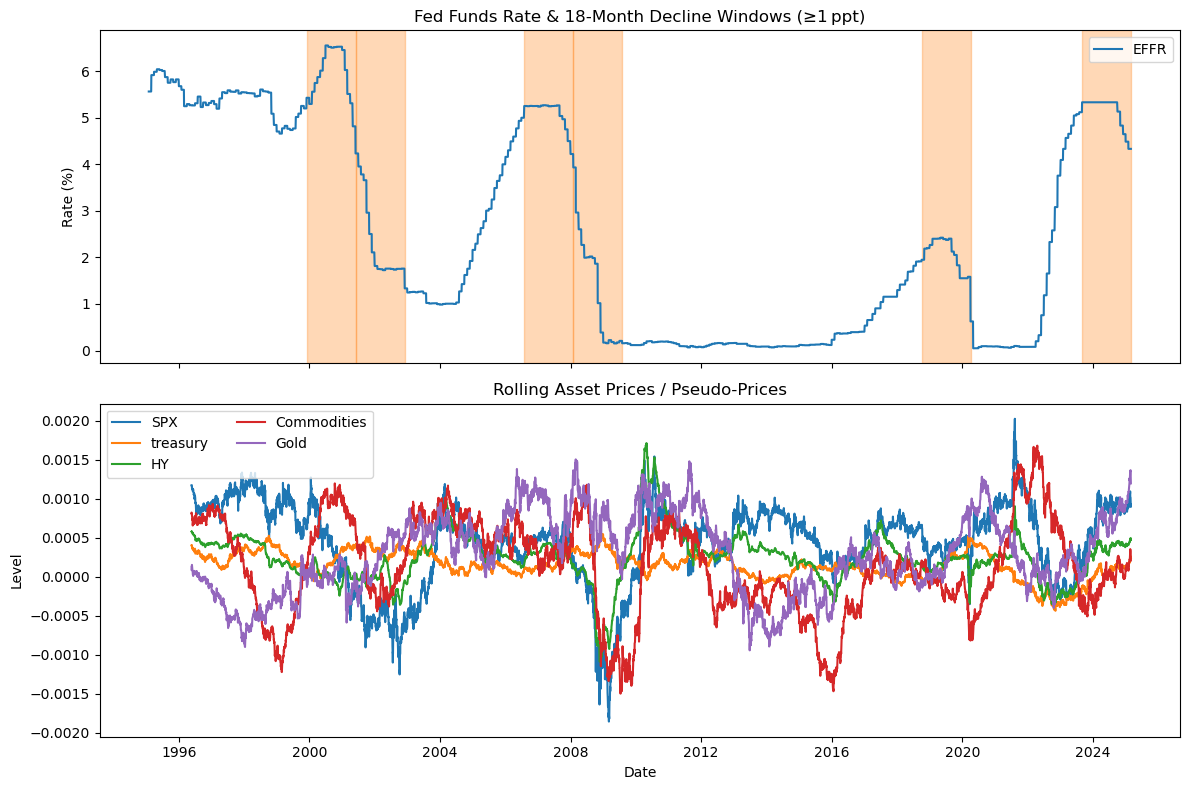

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top: Fed Funds with highlighted windows
ax1.plot(ff_rate.index, ff_rate.values, label='EFFR')
for d0 in regimes:
    t1 = ff_rate.index[ff_rate.index >= d0 + relativedelta(months=+HORIZON_MONTHS)][0]
    ax1.axvspan(d0, t1, color='C1', alpha=0.3)
ax1.set_title(f'Fed Funds Rate & {HORIZON_MONTHS}-Month Decline Windows (≥{DECLINE_THRESHOLD} ppt)')
ax1.set_ylabel('Rate (%)')
ax1.legend(loc='upper right')

# Bottom: Asset series
for col in raw_asset_px.columns:
    returns = raw_asset_px[col].pct_change().dropna().rolling(365).mean()
    ax2.plot(returns.index, returns, label=col)
ax2.set_title('Rolling Asset Prices / Pseudo‑Prices')
ax2.set_ylabel('Level')
ax2.legend(ncol=2, loc='upper left')

plt.xlabel('Date')
plt.tight_layout()
plt.show()


# Problem 3

Do you think your answer to (2) makes sense to extrapolate into how investors should
behave right now? Why or why not?

No, so far in 2025 we haven’t actually seen Fed cuts, and markets are behaving more like they’re still wrestling with sticky inflation and mixed growth signals. In addition, there seems to be abnormal correlations between equities and bonds. While the meaning this is up for debate, it may be a sign that the market is "selling the US" which may bias backtesting results to favor US equities in relation to the current market environment.



# Macro Regimes


## 4
We are looking at the ISM manufacturing index and the fed funds rate as our economic indicators. The ISM manufacturing index is a survey that tracks manufacturing activity within several industries. As an indicator it tells us about growth and econimic activity. Higher readings should indicate high growth, leading to higher equities prices. They can also be an indicator of future inflation which would drive up yields. I would also expect higher readings to increase commodities prices, as they may suggest higher short term demand for fuel and materials. The Fed Funds rate affects the risk free rate which has an impact across all asset prices. Higher fed funds rates directly affect yields, driving them higher. It also affects equities by changing the discount rate, which has an inverse affect on equities prices. Higher rates also have the effect of reducing economic activity as it gets more expensive for companies to invest in new projects. Due to the reduction of economic activity, I would expect higher rates to reduce commodities prices, as the lower activity would mean less demand for commodities in the short term.

## 5

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE1             = "Assignment_2_data.xlsm"
FILE3             = "macro_data_TR-fixed.xlsx"
ANNUAL_FACTOR = 252

In [ ]:
# Fed Funds (EFFR)
fed = pd.read_excel(FILE1, sheet_name='FF', index_col='Date')
fed = fed[~fed.index.duplicated(keep='last')]

fed = (fed            # daily EFFR
           .resample('ME').mean()      # calendar‑month mean
           .asfreq('B', method='ffill')  # fill forward to biz days
           [fed.index.min():])   # trim to asset window


fed['rates_slope'] = fed['Rate'].diff(252)

# Label regimes: 0, flat rates, -1, decreasing rates, 1, increasing rates
fed['regime'] = np.where(fed['rates_slope']<-0.5, 'Falling Rates', np.where(fed['rates_slope']>0.5, 'Rising Rates', 'Flat Rates'))
n = 126
fed['segment'] = (fed['regime'] != fed['regime'].shift(1)).cumsum()
fed['seg_size'] = fed.groupby('segment')['regime'].transform('size')
mask = (fed['seg_size']< n) & (fed['regime'] != 'Flat Rates')
fed.loc[mask, 'regime'] = 'Flat Rates'

# Fed Funds (EFFR)
ism = pd.read_excel(FILE1, sheet_name='ISM', index_col='Date')
ism = ism[~ism.index.duplicated(keep='last')]

ism = (ism            # daily EFFR
           .resample('ME').mean()      # calendar‑month mean
           .asfreq('B', method='ffill')  # fill forward to biz days
           [ism.index.min():])   # trim to asset window

spx = pd.read_excel(FILE1, sheet_name='SPTX', index_col='Date')
spx.rename(columns={'Price': 'SPX'}, inplace=True)
spx = spx[~spx.index.duplicated(keep='last')]
spx = spx[spx['SPX']>5]

treasury = pd.read_excel(FILE3, sheet_name='LUATTRUU', index_col='Date')
treasury = treasury[~treasury.index.duplicated(keep='last')]
treasury.rename(columns = {"PX_Last": "tbonds"}, inplace=True)


hy = pd.read_excel(FILE3, sheet_name='H0A0', index_col='Date')
hy = hy[~hy.index.duplicated(keep='last')]
hy.rename(columns = {"PX_Last":"hy"}, inplace=True)

# Commodities & Gold
commodities = pd.read_excel(FILE3, sheet_name='BCOMTR', index_col='Date')
commodities = commodities[~commodities.index.duplicated(keep='last')]
commodities.rename(columns = {'PX_Last': "com"}, inplace=True)




# Fed Rates Regimes

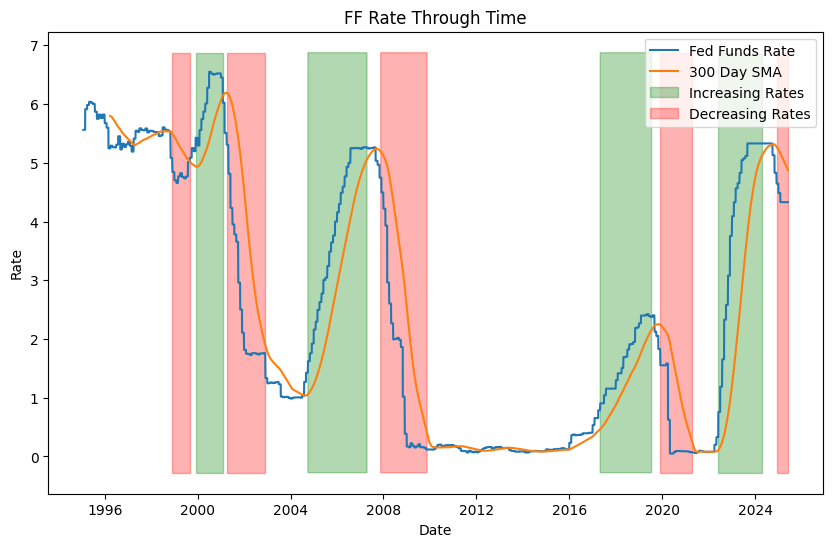

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(fed['Rate'], label = 'Fed Funds Rate')
ax.plot(fed['Rate'].rolling(window = 300).mean(), label = '300 Day SMA')
ymin, ymax = ax.get_ylim()
ax.fill_between(fed.index, ymin, ymax,
                where = (fed['regime']=='Rising Rates'),
                color = "green", alpha = 0.3,
                label = "Increasing Rates")
ax.fill_between(fed.index, ymin, ymax,
                where = (fed['regime']=='Falling Rates'),
                color = "red", alpha = 0.3,
                label = "Decreasing Rates")
ax.set_xlabel("Date")
ax.set_ylabel('Rate')
plt.legend(loc = 'upper right')
plt.title("FF Rate Through Time")
plt.show()

In [ ]:
fed['segment'] = (fed['regime'] != fed['regime'].shift(1)).cumsum()


periods = (
    fed
    .reset_index()                    
    .groupby(['segment','regime'])     
    .agg(
        start_date = ('Date', 'min'),
        end_date   = ('Date', 'max'),
        num_days     = ('Date', 'size')
    )
    .reset_index(drop=False)
)

periods = periods[periods['regime'] != 0].reset_index(drop=True)

periods


,segment,regime,start_date,end_date,num_days
0,1,Flat Rates,1995-01-31,1998-11-27,999
1,2,Falling Rates,1998-11-30,1999-08-30,196
2,3,Flat Rates,1999-08-31,1999-11-29,65
3,4,Rising Rates,1999-11-30,2001-01-30,306
4,5,Flat Rates,2001-01-31,2001-03-30,43
5,6,Falling Rates,2001-04-02,2002-11-18,426
6,7,Flat Rates,2002-11-19,2004-09-29,487
7,8,Rising Rates,2004-09-30,2007-04-17,664
8,9,Flat Rates,2007-04-18,2007-11-16,153
9,10,Falling Rates,2007-11-19,2009-11-17,522


In [ ]:
fed['spx'] = spx['SPX'].pct_change()
fed['com'] = commodities['com'].pct_change()
fed['hy'] = hy['hy'].pct_change()
fed['tr'] = treasury['tbonds'].pct_change()
asset_cols = ['spx', 'com', 'hy', 'tr']

In [ ]:


results = []
for (regime, seg_id), group in fed.groupby(['regime', 'segment']):
    eq = group['spx'].dropna()
    cred = group['hy'].dropna()
    comm = group['com'].dropna()
    treasuries = group['tr'].dropna()

    spx_avg_ret = eq.mean() * ANNUAL_FACTOR
    spx_vol = eq.std() * np.sqrt(ANNUAL_FACTOR)

    hy_avg_ret = cred.mean() * ANNUAL_FACTOR
    hy_vol = cred.std() * np.sqrt(ANNUAL_FACTOR)

    com_avg_ret = comm.mean() * ANNUAL_FACTOR
    com_vol = comm.std() * np.sqrt(ANNUAL_FACTOR)

    tr_avg_ret = treasuries.mean() * ANNUAL_FACTOR
    tr_vol = treasuries.std() * np.sqrt(ANNUAL_FACTOR)

    duration = len(group)
    if duration < 50:
        continue


    results.append({
        'regime': regime,
        'segment': seg_id,
        'start' : group.index.min(),
        'end': group.index.max(),
        'days': duration,
        'equities avg returns': spx_avg_ret,
        'equities vol': spx_vol,
        'high yield avg returns': hy_avg_ret,
        'high yield vol': hy_vol,
        'commodities avg returns': com_avg_ret,
        'commodities vol': com_vol,
        'treasuries avg returns': tr_avg_ret,
        'treasuries vol': tr_vol
    })

metrics_df = pd.DataFrame(results).set_index(['regime', 'segment'])
metrics_df


start        end  days  equities avg returns  \
regime        segment                                                     
Falling Rates 8       1998-11-30 1999-08-30   196              0.170217   
              12      2001-04-02 2002-11-18   426             -0.111266   
              24      2007-11-19 2009-11-17   522             -0.050937   
              28      2019-12-02 2021-04-16   360              0.272939   
              32      2024-12-02 2025-05-30   130             -0.250757   
Flat Rates    1       1995-01-31 1996-02-28   282              0.324472   
              2       1996-02-29 1996-07-30   109             -0.006364   
              7       1996-12-18 1998-11-27   508              0.289582   
              9       1999-08-31 1999-11-29    65              0.275433   
              17      2003-01-31 2003-04-16    54              0.239928   
              20      2003-06-30 2003-11-18   102              0.171553   
              21      2003-11-19 2004-09-29   226              0.111028   
              23      2007-04-18 2007-11-16   153              0.018196   
              25      2009-11-18 2017-04-28  1943              0.135549   
              27      2019-07-18 2019-11-29    97              0.165087   
              29      2021-04-19 2022-05-30   291              0.023909   
              31      2024-04-17 2024-11-29   163              0.305039   
Rising Rates  10      1999-11-30 2001-01-30   306              0.013975   
              22      2004-09-30 2007-04-17   664              0.133250   
              26      2017-05-01 2019-07-17   578              0.130730   
              30      2022-05-31 2024-04-16   491              0.135074   

                       equities vol  high yield avg returns  high yield vol  \
regime        segment                                                         
Falling Rates 8            0.188139                0.023279        0.019066   
              12           0.239594               -0.042755        0.056502   
              24           0.351060                0.063284        0.093305   
              28           0.302812                0.074284        0.097124   
              32           0.151343                0.022558        0.043149   
Flat Rates    1            0.088199                0.177086        0.021141   
              2            0.125735                0.028894        0.035561   
              7            0.190895                0.079784        0.028034   
              9            0.188123                0.000537        0.016315   
              17           0.225667                0.314591        0.030062   
              20           0.131055                0.135040        0.030054   
              21           0.112298                0.098155        0.026103   
              23           0.167888               -0.026170        0.037989   
              25           0.152164                0.079974        0.038571   
              27           0.137457                0.040256        0.025557   
              29           0.175960               -0.039791        0.042606   
              31           0.129368                0.133074        0.025978   
Rising Rates  10           0.218000                0.009679        0.028876   
              22           0.103489                0.082243        0.021354   
              26           0.134599                0.047924        0.027765   
              30           0.171834                0.044820        0.061481   

                       commodities avg returns  commodities vol  \
regime        segment                                             
Falling Rates 8                       0.133164         0.126939   
              12                      0.024546         0.134246   
              24                     -0.096531         0.270621   
              28                      0.100329         0.157579   
              32                      0.126109         0.138301   
Flat Rates    

In [ ]:
by_regime = metrics_df.reset_index().groupby('regime').agg({
        'equities avg returns': 'mean',
        'equities vol': 'mean',
        'high yield avg returns': 'mean',
        'high yield vol': 'mean',
        'commodities avg returns': 'mean',
        'commodities vol': 'mean',
        'treasuries avg returns': 'mean',
        'treasuries vol': 'mean',
        'days': ['mean', 'std'],
})

mapping = {
(   'equities avg returns', 'mean'): 'Equities Mean Return',
            (           'equities vol', 'mean'): 'Equities Mean Volatility',
            ( 'high yield avg returns', 'mean'): 'HY Mean Return',
            (         'high yield vol', 'mean'): 'HY Mean Volatility',
            ('commodities avg returns', 'mean'): 'Commodities Mean Return',
            (        'commodities vol', 'mean'): 'Commodities Mean Volatility',
            ( 'treasuries avg returns', 'mean'): 'Treasuries Mean Return',
            (         'treasuries vol', 'mean'): 'Treasuries Mean Volatility',
            (                   'days', 'mean'): 'Mean Length of Regime',
            (                   'days',  'std'): 'Length of Regime Standard Dev',
}
by_regime.columns = [
    mapping.get(col, col) for col in by_regime.columns
]
by_regime

,Equities Mean Return,Equities Mean Volatility,HY Mean Return,HY Mean Volatility,Commodities Mean Return,Commodities Mean Volatility,Treasuries Mean Return,Treasuries Mean Volatility,Mean Length of Regime,Length of Regime Standard Dev
regime,,,,,,,,,,
Falling Rates,0.006039,0.246590,0.028130,0.061829,0.057523,0.165537,0.035847,0.055663,326.80,161.929614
Flat Rates,0.171118,0.152068,0.085119,0.029831,0.100743,0.132240,0.042651,0.047623,332.75,522.992808
Rising Rates,0.103257,0.156981,0.046166,0.034869,0.066521,0.145870,0.036960,0.043634,509.75,153.097736


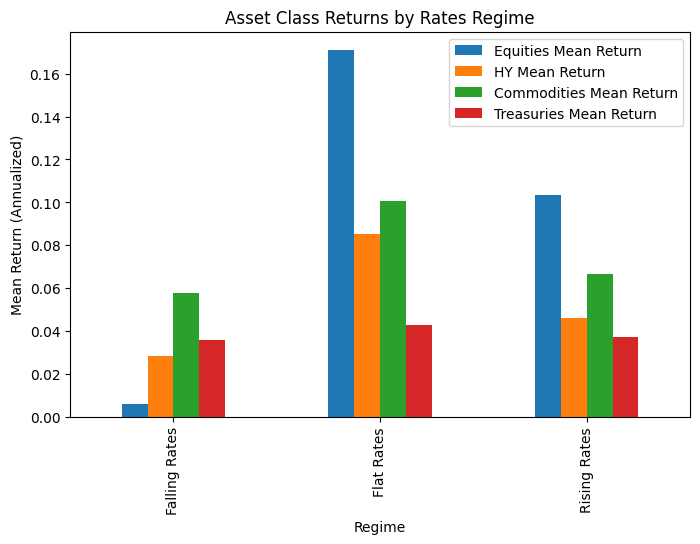

In [ ]:
mean_returns = by_regime[['Equities Mean Return', 'HY Mean Return', 'Commodities Mean Return', 'Treasuries Mean Return']]
ax = mean_returns.plot(kind='bar', 
                       figsize = (8, 5))
ax.set_title('Asset Class Returns by Rates Regime')
ax.set_ylabel('Mean Return (Annualized)')
ax.set_xlabel('Regime')

plt.show()

# ISM Regimes

In [ ]:
ism['spx'] = spx['SPX'].pct_change()
ism['com'] = commodities['com'].pct_change()
ism['hy'] = hy['hy'].pct_change()
ism['tr'] = treasury['tbonds'].pct_change()
asset_cols = ['spx', 'com', 'hy', 'tr']


In [ ]:
# Label regimes: 0, flat rates, -1, decreasing rates, 1, increasing rates
# f'avg_reading_{days}'
days = 126
ism[f'avg_reading_{days}'] = ism['ISM'].ewm(span = days).mean()
ism['regime'] = np.where(ism[f'avg_reading_{days}']<48, 'Contraction', np.where(ism[f'avg_reading_{days}']>52, 'Growth', 'Stability'))
n = 30
ism['segment'] = (ism['regime'] != ism['regime'].shift(1)).cumsum()
ism['seg_size'] = ism.groupby('segment')['regime'].transform('size')
mask = (ism['seg_size']< n) & (ism['regime'] != 'Stability')
ism.loc[mask, 'regime'] = 'Stability'

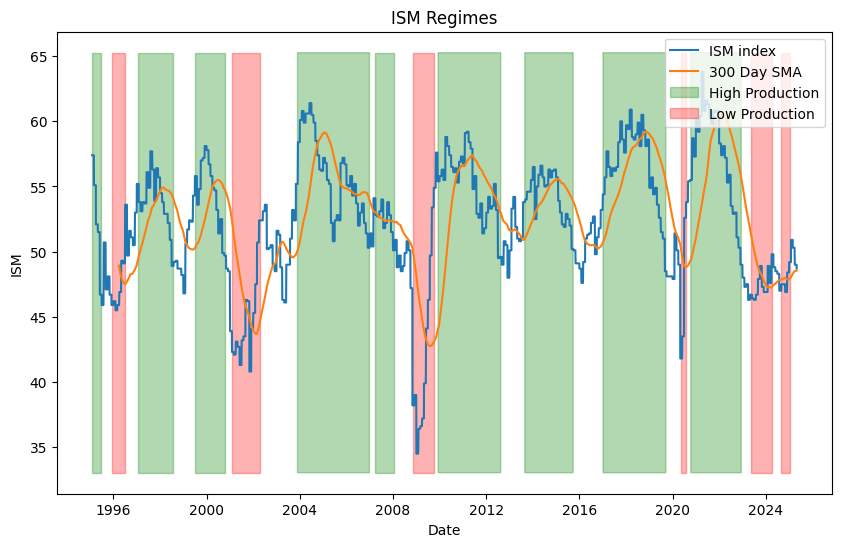

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(ism['ISM'], label = 'ISM index')
ax.plot(ism['ISM'].rolling(window = 300).mean(), label = '300 Day SMA')
ymin, ymax = ax.get_ylim()
ax.fill_between(ism.index, ymin, ymax,
                where = (ism['regime']=='Growth'),
                color = "green", alpha = 0.3,
                label = "High Production")
ax.fill_between(ism.index, ymin, ymax,
                where = (ism['regime']=='Contraction'),
                color = "red", alpha = 0.3,
                label = "Low Production")
ax.set_xlabel("Date")
ax.set_ylabel('ISM')
plt.legend(loc = 'upper right')
plt.title("ISM Regimes")
plt.show()

In [ ]:
ism['segment'] = (ism['regime'] != ism['regime'].shift(1)).cumsum()


periods = (
    ism
    .reset_index()                    
    .groupby(['segment','regime'])     
    .agg(
        start_date = ('Date', 'min'),
        end_date   = ('Date', 'max'),
        num_days     = ('Date', 'size')
    )
    .reset_index(drop=False)
)

periods = periods[periods['regime'] != 0].reset_index(drop=True)

periods

,segment,regime,start_date,end_date,num_days
0,1,Growth,1995-01-31,1995-06-12,95
1,2,Stability,1995-06-13,1995-11-30,123
2,3,Contraction,1995-12-01,1996-07-01,152
3,4,Stability,1996-07-02,1997-01-17,144
4,5,Growth,1997-01-20,1998-07-15,388
5,6,Stability,1998-07-16,1999-06-28,248
6,7,Growth,1999-06-29,2000-10-13,339
7,8,Stability,2000-10-16,2001-02-02,80
8,9,Contraction,2001-02-05,2002-04-19,315
9,10,Stability,2002-04-22,2003-11-24,416


In [ ]:


results = []
for (regime, seg_id), group in ism.groupby(['regime', 'segment']):
    eq = group['spx'].dropna()
    cred = group['hy'].dropna()
    comm = group['com'].dropna()
    treasuries = group['tr'].dropna()

    spx_avg_ret = eq.mean() * ANNUAL_FACTOR
    spx_vol = eq.std() * np.sqrt(ANNUAL_FACTOR)

    hy_avg_ret = cred.mean() * ANNUAL_FACTOR
    hy_vol = cred.std() * np.sqrt(ANNUAL_FACTOR)

    com_avg_ret = comm.mean() * ANNUAL_FACTOR
    com_vol = comm.std() * np.sqrt(ANNUAL_FACTOR)

    tr_avg_ret = treasuries.mean() * ANNUAL_FACTOR
    tr_vol = treasuries.std() * np.sqrt(ANNUAL_FACTOR)

    duration = len(group)
    if duration < 50:
        continue


    results.append({
        'regime': regime,
        'segment': seg_id,
        'start' : group.index.min(),
        'end': group.index.max(),
        'days': duration,
        'equities avg returns': spx_avg_ret,
        'equities vol': spx_vol,
        'high yield avg returns': hy_avg_ret,
        'high yield vol': hy_vol,
        'commodities avg returns': com_avg_ret,
        'commodities vol': com_vol,
        'treasuries avg returns': tr_avg_ret,
        'treasuries vol': tr_vol
    })

metrics_df = pd.DataFrame(results).set_index(['regime', 'segment'])
metrics_df


start        end  days  equities avg returns  \
regime      segment                                                     
Contraction 3       1995-12-01 1996-07-01   152              0.217926   
            9       2001-02-05 2002-04-19   315             -0.116956   
            15      2008-11-11 2009-10-09   239              0.258815   
            23      2020-05-19 2020-07-27    50              0.526362   
            27      2023-05-12 2024-04-12   241              0.257737   
            29      2024-08-29 2025-01-14    99              0.139431   
Growth      1       1995-01-31 1995-06-12    95              0.375069   
            5       1997-01-20 1998-07-15   388              0.309741   
            7       1999-06-29 2000-10-13   339              0.056155   
            11      2003-11-25 2006-12-28   808              0.121806   
            13      2007-03-21 2008-01-17   217             -0.034150   
            17      2009-12-08 2012-08-15   702              0.129193   
            19      2013-08-28 2015-09-25   543              0.110195   
            21      2017-01-05 2019-09-17   704              0.132770   
            25      2020-10-13 2022-12-13   566              0.092835   
Stability   2       1995-06-13 1995-11-30   123              0.303331   
            4       1996-07-02 1997-01-17   144              0.278809   
            6       1998-07-16 1999-06-28   248              0.171142   
            8       2000-10-16 2001-02-02    80             -0.021322   
            10      2002-04-22 2003-11-24   416              0.003167   
            12      2006-12-29 2007-03-20    58             -0.017995   
            14      2008-01-18 2008-11-10   212             -0.361116   
            18      2012-08-16 2013-08-27   269              0.174009   
            20      2015-09-28 2017-01-04   333              0.158506   
            22      2019-09-18 2020-05-18   174              0.068456   
            24      2020-07-28 2020-10-12    55              0.441521   
            26      2022-12-14 2023-05-11   107              0.096738   
            28      2024-04-15 2024-08-28    98              0.254610   
            30      2025-01-15 2025-04-30    76             -0.248561   

                     equities vol  high yield avg returns  high yield vol  \
regime      segment                                                         
Contraction 3            0.115183                0.075891        0.027962   
            9            0.200947                0.007237        0.044397   
            15           0.358663                0.407994        0.094600   
            23           0.222095                0.418620        0.075404   
            27           0.115088                0.091960        0.042529   
            29           0.128237                0.046645        0.022956   
Growth      1            0.078366                0.273725        0.023650   
            5            0.167959                0.113915        0.018155   
            7            0.200963               -0.013055        0.019781   
            11           0.104467                0.083413        0.023158   
            13           0.175276               -0.031443        0.037046   
            17           0.191143                0.108397        0.039544   
            19           0.127398                0.026626        0.029379   
            21           0.131371                0.055740        0.027819   
            25           0.191014                0.003347        0.054879   
Stability   2            0.077165                0.117479        0.019242   
            4            0.118225                0.142748        0.025241   
            6            0.227547               -0.000085        0.035104   
            8            0.237703                0.099465        0.045240   
            10           0.234218                0.106114        0.051964   
            12           0.121852                0.110759        0.

In [ ]:
by_regime = metrics_df.reset_index().groupby('regime').agg({
        'equities avg returns': 'mean',
        'equities vol': 'mean',
        'high yield avg returns': 'mean',
        'high yield vol': 'mean',
        'commodities avg returns': 'mean',
        'commodities vol': 'mean',
        'treasuries avg returns': 'mean',
        'treasuries vol': 'mean',
        'days': ['mean', 'std'],
})

mapping = {
(   'equities avg returns', 'mean'): 'Equities Mean Return',
            (           'equities vol', 'mean'): 'Equities Mean Volatility',
            ( 'high yield avg returns', 'mean'): 'HY Mean Return',
            (         'high yield vol', 'mean'): 'HY Mean Volatility',
            ('commodities avg returns', 'mean'): 'Commodities Mean Return',
            (        'commodities vol', 'mean'): 'Commodities Mean Volatility',
            ( 'treasuries avg returns', 'mean'): 'Treasuries Mean Return',
            (         'treasuries vol', 'mean'): 'Treasuries Mean Volatility',
            (                   'days', 'mean'): 'Mean Length of Regime',
            (                   'days',  'std'): 'Length of Regime Standard Dev',
}
by_regime.columns = [
    mapping.get(col, col) for col in by_regime.columns
]
by_regime

,Equities Mean Return,Equities Mean Volatility,HY Mean Return,HY Mean Volatility,Commodities Mean Return,Commodities Mean Volatility,Treasuries Mean Return,Treasuries Mean Volatility,Mean Length of Regime,Length of Regime Standard Dev
regime,,,,,,,,,,
Contraction,0.213886,0.190035,0.174725,0.051308,0.166025,0.143126,0.008895,0.052884,182.666667,99.628644
Growth,0.143735,0.151995,0.068963,0.030379,0.078574,0.134872,0.065282,0.041331,484.666667,240.819434
Stability,0.092950,0.191206,0.048219,0.048837,-0.014295,0.146060,0.071511,0.049760,170.928571,110.759937


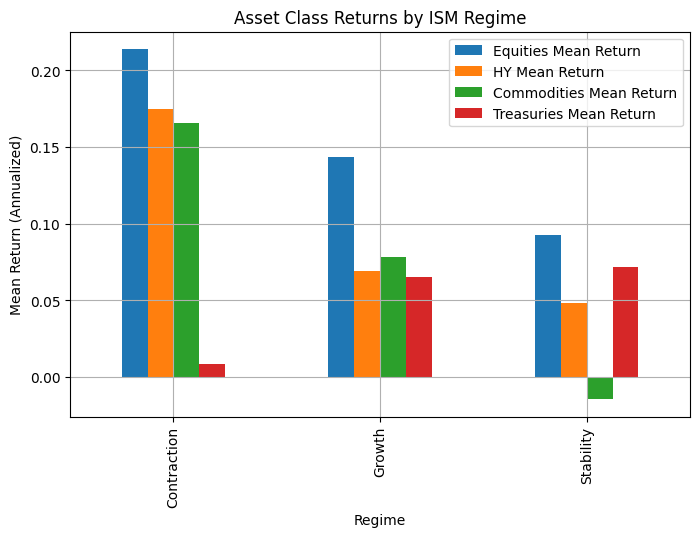

In [ ]:
mean_returns = by_regime[['Equities Mean Return', 'HY Mean Return', 'Commodities Mean Return', 'Treasuries Mean Return']]
ax = mean_returns.plot(kind='bar', 
                       figsize = (8, 5))
ax.set_title('Asset Class Returns by ISM Regime')
ax.set_ylabel('Mean Return (Annualized)')
ax.set_xlabel('Regime')
plt.grid()

plt.show()

# Group Only by Regime

## FF

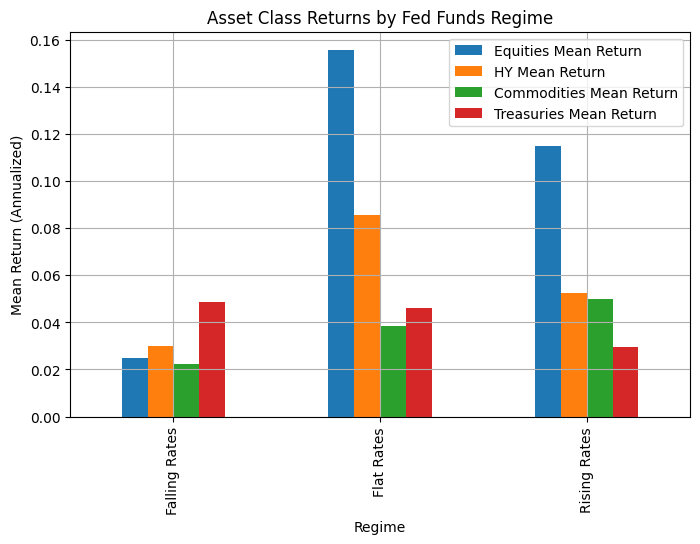

In [ ]:
def annualized_mean(x):
    return x.mean() * ANNUAL_FACTOR

def annualized_vol(x):
    return x.std() * np.sqrt(ANNUAL_FACTOR)

by_regime = fed.reset_index().groupby('regime').agg({
        'spx': [('mean', annualized_mean), ('std', annualized_vol)],
        'hy': [('mean', annualized_mean), ('std', annualized_vol)],
        'com': [('mean', annualized_mean), ('std', annualized_vol)],
        'tr': [('mean', annualized_mean), ('std', annualized_vol)],
})

mapping = {
(   'spx', 'mean'): 'Equities Mean Return',
            (           'spx', 'std'): 'Equities Volatility',
            ( 'hy', 'mean'): 'HY Mean Return',
            (         'hy', 'std'): 'HY Volatility',
            ('com', 'mean'): 'Commodities Mean Return',
            (        'com', 'std'): 'Commodities Volatility',
            ( 'tr', 'mean'): 'Treasuries Mean Return',
            (         'tr', 'std'): 'Treasuries Volatility',
}
by_regime.columns = [
    mapping.get(col, col) for col in by_regime.columns
]

mean_returns = by_regime[['Equities Mean Return', 'HY Mean Return', 'Commodities Mean Return', 'Treasuries Mean Return']]
ax = mean_returns.plot(kind='bar', 
                       figsize = (8, 5))
ax.set_title('Asset Class Returns by Fed Funds Regime')
ax.set_ylabel('Mean Return (Annualized)')
ax.set_xlabel('Regime')
plt.grid()

plt.show()

In [ ]:
round(mean_returns.T, 4)

regime,Falling Rates,Flat Rates,Rising Rates
Equities Mean Return,0.0250,0.1556,0.1151
HY Mean Return,0.0302,0.0856,0.0526
Commodities Mean Return,0.0223,0.0385,0.0499
Treasuries Mean Return,0.0485,0.0459,0.0295


In [ ]:
vol_cols = by_regime[['Equities Volatility', 'HY Volatility', 'Commodities Volatility', 'Treasuries Volatility']]
round(vol_cols.T, 4)

regime,Falling Rates,Flat Rates,Rising Rates
Equities Volatility,0.2876,0.1554,0.1511
HY Volatility,0.0770,0.0347,0.0375
Commodities Volatility,0.1931,0.1377,0.1489
Treasuries Volatility,0.0595,0.0437,0.0451


## ISM

In [ ]:
def annualized_mean(x):
    return x.mean() * ANNUAL_FACTOR

def annualized_vol(x):
    return x.std() * np.sqrt(ANNUAL_FACTOR)

by_regime = ism.reset_index().groupby('regime').agg({
        'spx': [('mean', annualized_mean), ('std', annualized_vol)],
        'hy': [('mean', annualized_mean), ('std', annualized_vol)],
        'com': [('mean', annualized_mean), ('std', annualized_vol)],
        'tr': [('mean', annualized_mean), ('std', annualized_vol)],
})

mapping = {
(   'spx', 'mean'): 'Equities Mean Return',
            (           'spx', 'std'): 'Equities Volatility',
            ( 'hy', 'mean'): 'HY Mean Return',
            (         'hy', 'std'): 'HY Volatility',
            ('com', 'mean'): 'Commodities Mean Return',
            (        'com', 'std'): 'Commodities Volatility',
            ( 'tr', 'mean'): 'Treasuries Mean Return',
            (         'tr', 'std'): 'Treasuries Volatility',
}
by_regime.columns = [
    mapping.get(col, col) for col in by_regime.columns
]
by_regime

,Equities Mean Return,Equities Volatility,HY Mean Return,HY Volatility,Commodities Mean Return,Commodities Volatility,Treasuries Mean Return,Treasuries Volatility
regime,,,,,,,,
Contraction,0.146031,0.219344,0.145809,0.058572,0.081401,0.168222,0.015146,0.057745
Growth,0.128914,0.157299,0.058998,0.033551,0.062353,0.148147,0.040549,0.041782
Stability,0.088439,0.222519,0.041504,0.060277,-0.024858,0.155568,0.058429,0.052376


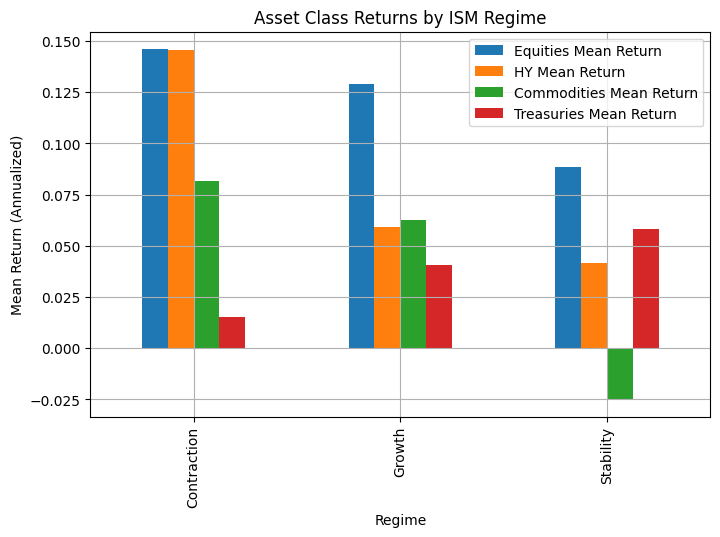

In [ ]:
mean_returns = by_regime[['Equities Mean Return', 'HY Mean Return', 'Commodities Mean Return', 'Treasuries Mean Return']]
ax = mean_returns.plot(kind='bar', 
                       figsize = (8, 5))
ax.set_title('Asset Class Returns by ISM Regime')
ax.set_ylabel('Mean Return (Annualized)')
ax.set_xlabel('Regime')
plt.grid()

plt.show()

In [ ]:
round(mean_returns.T, 4)

regime,Contraction,Growth,Stability
Equities Mean Return,0.1460,0.1289,0.0884
HY Mean Return,0.1458,0.0590,0.0415
Commodities Mean Return,0.0814,0.0624,-0.0249
Treasuries Mean Return,0.0151,0.0405,0.0584
